In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

### Architecture idea (SIMPLE DIAGRAM)

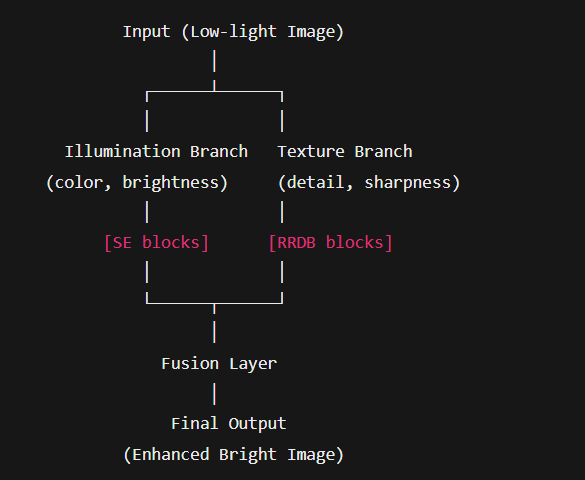

In [111]:
!pip install numpy
!pip install torchmetrics
!pip install piq
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 17.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 KB 21.8 MB/s eta 0:00:00


In [95]:
import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import PeakSignalNoiseRatio as PSNR, StructuralSimilarityIndexMeasure as SSIM
from piq import LPIPS
import os
import torch.nn.functional as F
from torchvision.models import vgg19
from torchvision.utils import save_image
from torchvision.datasets import DatasetFolder
from datetime import datetime
from sklearn.model_selection import train_test_split

In [ ]:
# def set_seed(seed=42):
#     """Set all random seeds for reproducibility."""
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)  # if using multi-GPU
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# # Set the seed (choose any number you like)
# set_seed(42) 

# Run Data

In [96]:
dataset_path1 = '/home/gsalsabil2/dl_kapel/no_augment_images'
train_path = f'{dataset_path1}/train'
val_path = f'{dataset_path1}/val'
test_path = f'{dataset_path1}/test'

In [97]:
target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [98]:
class CleanDataset(Dataset):
    def __init__(self, root_dir, target_transform=None):
        self.root_dir = root_dir
        self.target_transform = target_transform
        self.low_dir = os.path.join(root_dir, "low")
        self.high_dir = os.path.join(root_dir, "high")
        self.image_names = sorted(os.listdir(self.low_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        low_img_path = os.path.join(self.low_dir, self.image_names[idx])
        high_img_path = os.path.join(self.high_dir, self.image_names[idx])

        low_img = Image.open(low_img_path).convert("RGB")
        high_img = Image.open(high_img_path).convert("RGB")

        if self.target_transform:
            low_img = self.target_transform(low_img)
            high_img = self.target_transform(high_img)
            
            
        low_filename = os.path.basename(low_img_path)
        high_filename = os.path.basename(high_img_path)
        
        return low_img, high_img, low_filename, high_filename

train_dataset = CleanDataset(
    root_dir=train_path, 
    target_transform = target_transform
)

val_dataset = CleanDataset(
    root_dir=val_path,
    target_transform = target_transform
)

test_dataset = CleanDataset(root_dir=test_path, target_transform = target_transform)

In [99]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True   # Speeds up transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,         # No need for validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,       # Often use batch_size=1 for testing
    shuffle=False,
    num_workers=1
)

In [100]:
def show_true_images(low_batch, high_batch, n=4):

    """
    Shows EXACTLY what's in your dataset with correct color handling.
    Works for both normalized and unnormalized images.
    """

    plt.figure(figsize=(18, 8))

    for i in range(min(n, len(low_batch))):
        # --- Low-light ---
        plt.subplot(2, n, i+1)
        low_img = low_batch[i].permute(1, 2, 0).numpy()

        # Handle normalization if present
        if low_img.min() < 0:  # Likely normalized
            low_img = (low_img * 0.5 + 0.5)  # Reverse imagenet norm

        # Ensure proper image range
        low_img = np.clip(low_img, 0, 1)
        plt.imshow(low_img)
        plt.title(f"Low")
        plt.axis('off')

        # --- Normal-light ---
        plt.subplot(2, n, n+i+1)
        high_img = high_batch[i].permute(1, 2, 0).numpy()

        if high_img.min() < 0:  # Likely normalized
            high_img = (high_img * 0.5 + 0.5)

        high_img = np.clip(high_img, 0, 1)
        plt.imshow(high_img)
        plt.title(f"High")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Low resolution file name: ['761.png', '777.png', '542.png', '560.png', '112.png', '194.png', '764.png', '543.png']
High resolution file name: ['761.png', '777.png', '542.png', '560.png', '112.png', '194.png', '764.png', '543.png']


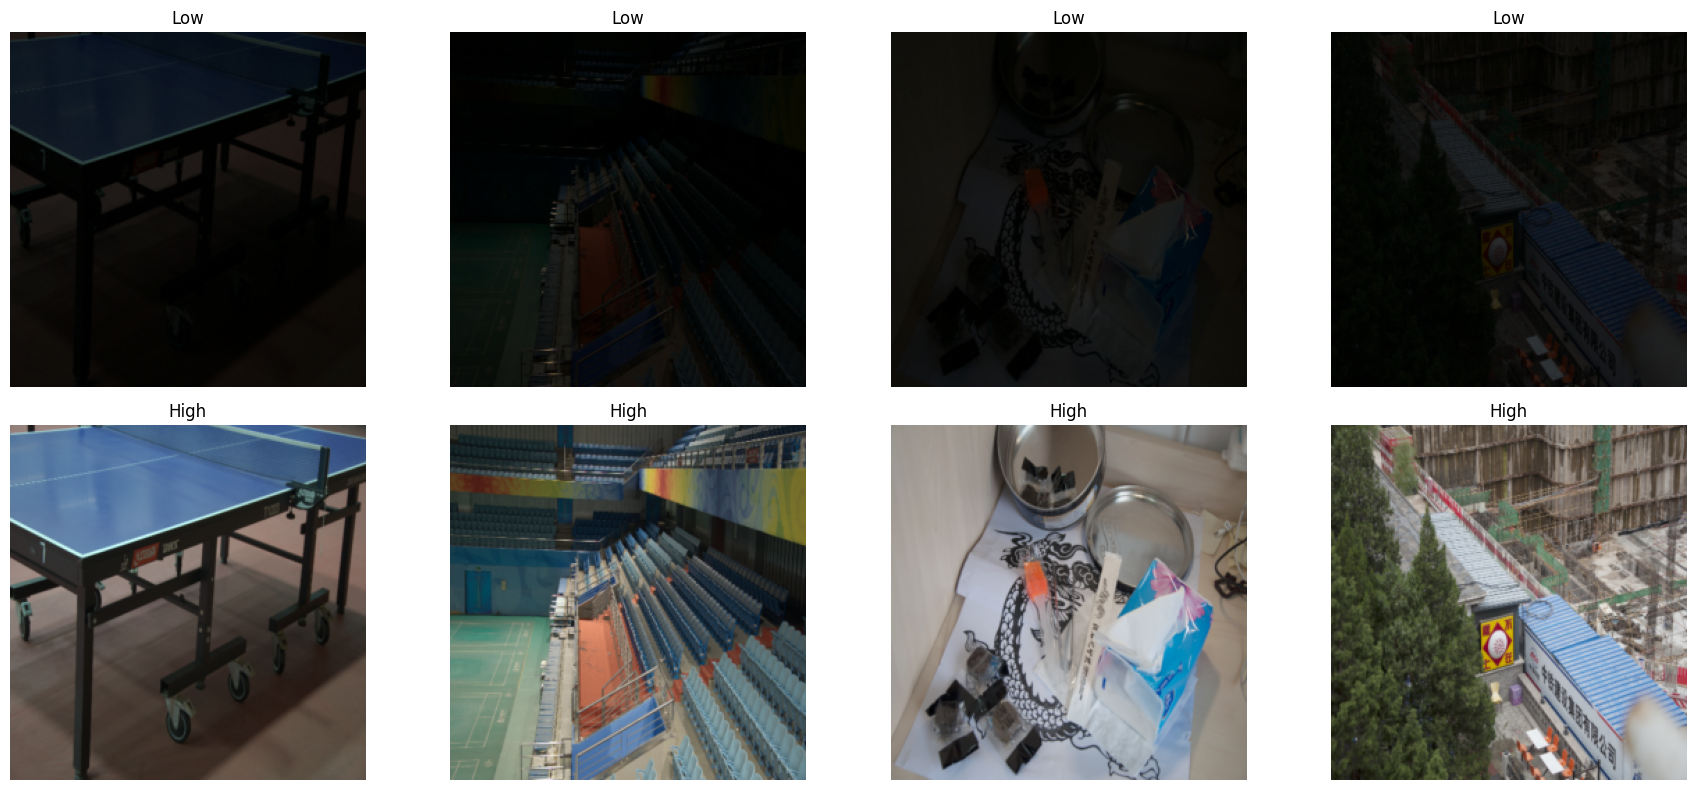

In [101]:
low, high, low_filename, high_filename = next(iter(train_loader))
print("Low resolution file name:", low_filename)
print("High resolution file name:", high_filename)
show_true_images(low, high)

# MODEL ARCHITECTURE

In [102]:
#SE Blocks:

class SEBlock(nn.Module):
    """Squeeze-and-Excitation block for channel attention"""

    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


# Residual-in-Residual Dense Block (RRDB)

class RRDB(nn.Module):
    """Residual-in-Residual Dense Block"""
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels*2, channels, 3, padding=1)
        self.conv3 = nn.Conv2d(channels*3, channels, 3, padding=1)
        self.lrelu = nn.LeakyReLU(0.2)
        self.se = SEBlock(channels)

    def forward(self, x):
        out1 = self.lrelu(self.conv1(x))
        out2 = self.lrelu(self.conv2(torch.cat([x, out1], 1)))
        out3 = self.conv3(torch.cat([x, out1, out2], 1))
        return self.se(out3 * 0.2 + x)  # Residual scaling


Generator


In [103]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # Illumination Branch (color/brightness)
        self.illum_conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.illum_rrdb = nn.Sequential(*[RRDB(32) for _ in range(4)])
        self.illum_conv2 = nn.Conv2d(32, 3, 3, padding=1)

        # Texture Branch (detail/sharpness)
        self.texture_conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.texture_rrdb = nn.Sequential(*[RRDB(64) for _ in range(6)])
        self.texture_conv2 = nn.Conv2d(64, 3, 3, padding=1)

        # Fusion
        self.fusion = nn.Sequential(
            nn.Conv2d(6, 32, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Tanh()  # Output in [-1,1] -> remap to [0,1] later
        )

    def forward(self, x):
        # Illumination path
        illum = self.illum_conv1(x)
        illum = self.illum_rrdb(illum)
        illum = torch.sigmoid(self.illum_conv2(illum))  # [0,1]

        # Texture path
        texture = self.texture_conv1(x)
        texture = self.texture_rrdb(texture)
        texture = self.texture_conv2(texture)  # No activation (keep details)

        # Fusion
        fused = self.fusion(torch.cat([illum, texture], 1))
        return (fused + 1) / 2  # Map to [0,1]

Discriminator

In [104]:
class Discriminator(nn.Module):
    """PatchGAN discriminator"""
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Input: 3 x 256 x 256
            nn.Conv2d(3, 64, 4, stride=2, padding=1),  # 128
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 64
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # 32
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, stride=1, padding=1),  # 31
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, stride=1, padding=1)  # 30x30 patch output
        )

    def forward(self, x):
        return self.model(x)

Loss Functions


In [105]:
class GANLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, pred, target_is_real):
        target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
        return self.loss(pred, target)


class PerceptualLoss(nn.Module):

    """VGG-based perceptual loss"""

    def __init__(self):
        super().__init__()
        vgg = vgg19(pretrained=True).features[:16]
        self.vgg = nn.Sequential(*[m for m in vgg if not isinstance(m, nn.MaxPool2d)])
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        vgg_input = F.interpolate(input, size=(224,224)) if input.shape[-1] != 224 else input
        vgg_target = F.interpolate(target, size=(224,224)) if target.shape[-1] != 224 else target
        return F.l1_loss(self.vgg(vgg_input), self.vgg(vgg_target))

# Training preparation:

In [106]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Hyperparameters
config = {
    'batch_size': 8,
    'epochs': 200,
    'lr_g': 2e-4,
    'lr_d': 1e-4,
    'betas': (0.5, 0.999),
    'lambda_l1': 100,
    'lambda_perceptual': 0.1,
    'save_interval': 1,  # Save every epoch
    'sample_interval': 100,  # Generate samples every N batches
}

# Initialize models and losses
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Losses
criterion_gan = GANLoss()
criterion_l1 = nn.L1Loss()
criterion_perceptual = PerceptualLoss().to(device)

# Optimizers with LR scheduling
opt_g = torch.optim.Adam(generator.parameters(), lr=config['lr_g'], betas=config['betas'])
opt_d = torch.optim.Adam(discriminator.parameters(), lr=config['lr_d'], betas=config['betas'])
scheduler_g = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_g, 'min', patience=5, factor=0.5)
scheduler_d = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_d, 'min', patience=5, factor=0.5)

# Initialize metrics
psnr = PSNR().to(device)
ssim = SSIM().to(device)
lpips = LPIPS(replace_pooling=True).to(device)

# Training LOOP

In [107]:
def validate(generator, val_loader, epoch):
    """Evaluate model on validation set"""
    generator.eval()
    val_metrics = {'psnr': 0, 'ssim': 0, 'lpips': 0}

    with torch.no_grad():
        for low, high, *_ in tqdm(val_loader, desc=f'Validation Epoch {epoch}', leave=False):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Update metrics
            val_metrics['psnr'] += psnr(fake, high)
            val_metrics['ssim'] += ssim(fake, high)
            val_metrics['lpips'] += lpips(fake, high)

    # Average across batches
    for k in val_metrics:
        val_metrics[k] /= len(val_loader)

    return val_metrics

In [108]:
def train_gan(
    generator,
    discriminator,
    train_loader,
    val_loader,
    criterion_gan,
    criterion_l1,
    criterion_perceptual,
    opt_g,
    opt_d,
    epochs,
    device,
    save_dir="NOAUG_RRDB_SE_CHECKPOINTS"
):
    os.makedirs(save_dir, exist_ok=True)
    best_ssim = 0
    best_lpips = 100
    best_psnr = 0

    for epoch in range(epochs):
        # Training phase
        generator.train()
        discriminator.train()

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for low, high, *_ in train_bar:
            low, high = low.to(device), high.to(device)

            # --- Discriminator Update ---
            opt_d.zero_grad()

            # Real images
            real_pred = discriminator(high)
            real_loss = criterion_gan(real_pred, True)

            # Fake images
            fake = generator(low).detach()
            fake_pred = discriminator(fake)
            fake_loss = criterion_gan(fake_pred, False)

            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            opt_d.step()

            # --- Generator Update ---
            opt_g.zero_grad()
            fake = generator(low)
            g_gan_loss = criterion_gan(discriminator(fake), True)
            g_l1_loss = criterion_l1(fake, high) * 100
            g_perc_loss = criterion_perceptual(fake, high) * 0.1
            g_loss = g_gan_loss + g_l1_loss + g_perc_loss
            g_loss.backward()
            opt_g.step()

            # Update progress bar
            train_bar.set_postfix({
                'D_loss': f'{d_loss.item():.3f}',
                'G_loss': f'{g_loss.item():.3f}',
                'L1': f'{g_l1_loss.item():.3f}'
            })

        # Validation phase
        val_metrics = validate(generator, val_loader, epoch+1)

        # Print metrics
        print(f"\nValidation @ Epoch {epoch+1}:")
        print(f"PSNR: {val_metrics['psnr']:.2f} dB | SSIM: {val_metrics['ssim']:.4f} | LPIPS: {val_metrics['lpips']:.4f}")

        # Save checkpoint
        torch.save({
            'epoch': epoch+1,
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'opt_g': opt_g.state_dict(),
            'opt_d': opt_d.state_dict(),
            'metrics': val_metrics
        }, os.path.join(save_dir, f'epoch_{epoch+1}.pth'))

        # Save best model
        if (val_metrics['psnr'] > best_psnr) and (val_metrics['lpips'] < best_lpips) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_model.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['lpips'] < best_lpips) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips_ssim.pth'))
            print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['psnr'] > best_psnr) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_ssim.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['psnr'] > best_psnr) and (val_metrics['lpips'] < best_lpips):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_lpips.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f}) saved!")
                
        if val_metrics['ssim'] > best_ssim:
            best_ssim = val_metrics['ssim']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_ssim.pth'))
            print(f"🔥 New best model (SSIM: {best_ssim:.4f}) saved!")
                    
        if val_metrics['psnr'] > best_psnr:
            best_psnr = val_metrics['psnr']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr.pth'))
            print(f"🔥 New best model (PSNR: {best_psnr:.4f}) saved!")

        if val_metrics['lpips'] < best_lpips:
            best_lpips = val_metrics['lpips']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
            print(f"🔥 New best model (LPIPS: {best_lpips:.4f}) saved!")

            
        # Sample images
        if (epoch+1) % 5 == 0:
            with torch.no_grad():
                fake = generator(low[:3])  # First 3 samples
                save_image(
                    torch.cat([low[:3], fake, high[:3]], 0),
                    os.path.join(save_dir, f'sample_epoch_{epoch+1}.png'),
                    nrow=3,
                    normalize=True
                )


In [109]:
# Usage
train_gan(
    generator=generator,
    discriminator=discriminator,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion_gan=criterion_gan,
    criterion_l1=criterion_l1,
    criterion_perceptual=criterion_perceptual,
    opt_g=opt_g,
    opt_d=opt_d,
    epochs=200,
    device=device
)

Epoch 1/200:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/200: 100%|██████████| 49/49 [00:23<00:00,  2.04it/s, D_loss=0.263, G_loss=18.972, L1=17.234]



Validation @ Epoch 1:
PSNR: 15.10 dB | SSIM: 0.6040 | LPIPS: 0.4977
🔥 New best model (PSNR: 15.0995 | LPIPS: 0.4977 | SSIM: 0.6040) saved!
🔥 New best model (LPIPS: 0.4977 | SSIM: 0.6040) saved!
🔥 New best model (PSNR: 15.0995 | SSIM: 0.6040) saved!
🔥 New best model (PSNR: 15.0995 | LPIPS: 0.4977) saved!
🔥 New best model (SSIM: 0.6040) saved!
🔥 New best model (PSNR: 15.0995) saved!
🔥 New best model (LPIPS: 0.4977) saved!


Epoch 2/200: 100%|██████████| 49/49 [00:24<00:00,  2.03it/s, D_loss=0.340, G_loss=19.493, L1=17.286]



Validation @ Epoch 2:
PSNR: 15.50 dB | SSIM: 0.6260 | LPIPS: 0.4928
🔥 New best model (PSNR: 15.5050 | LPIPS: 0.4928 | SSIM: 0.6260) saved!
🔥 New best model (LPIPS: 0.4928 | SSIM: 0.6260) saved!
🔥 New best model (PSNR: 15.5050 | SSIM: 0.6260) saved!
🔥 New best model (PSNR: 15.5050 | LPIPS: 0.4928) saved!
🔥 New best model (SSIM: 0.6260) saved!
🔥 New best model (PSNR: 15.5050) saved!
🔥 New best model (LPIPS: 0.4928) saved!


Epoch 3/200: 100%|██████████| 49/49 [00:24<00:00,  2.02it/s, D_loss=0.062, G_loss=12.023, L1=8.866] 



Validation @ Epoch 3:
PSNR: 16.88 dB | SSIM: 0.6595 | LPIPS: 0.4751
🔥 New best model (PSNR: 16.8792 | LPIPS: 0.4751 | SSIM: 0.6595) saved!
🔥 New best model (LPIPS: 0.4751 | SSIM: 0.6595) saved!
🔥 New best model (PSNR: 16.8792 | SSIM: 0.6595) saved!
🔥 New best model (PSNR: 16.8792 | LPIPS: 0.4751) saved!
🔥 New best model (SSIM: 0.6595) saved!
🔥 New best model (PSNR: 16.8792) saved!
🔥 New best model (LPIPS: 0.4751) saved!


Epoch 4/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.047, G_loss=15.837, L1=12.368]



Validation @ Epoch 4:
PSNR: 16.67 dB | SSIM: 0.6609 | LPIPS: 0.4928
🔥 New best model (SSIM: 0.6609) saved!


Epoch 5/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.125, G_loss=12.078, L1=9.240] 



Validation @ Epoch 5:
PSNR: 16.39 dB | SSIM: 0.6514 | LPIPS: 0.5248


Epoch 6/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.103, G_loss=11.049, L1=8.468] 



Validation @ Epoch 6:
PSNR: 17.42 dB | SSIM: 0.7271 | LPIPS: 0.4201
🔥 New best model (PSNR: 17.4225 | LPIPS: 0.4201 | SSIM: 0.7271) saved!
🔥 New best model (LPIPS: 0.4201 | SSIM: 0.7271) saved!
🔥 New best model (PSNR: 17.4225 | SSIM: 0.7271) saved!
🔥 New best model (PSNR: 17.4225 | LPIPS: 0.4201) saved!
🔥 New best model (SSIM: 0.7271) saved!
🔥 New best model (PSNR: 17.4225) saved!
🔥 New best model (LPIPS: 0.4201) saved!


Epoch 7/200: 100%|██████████| 49/49 [00:23<00:00,  2.04it/s, D_loss=0.100, G_loss=11.391, L1=8.484] 



Validation @ Epoch 7:
PSNR: 17.14 dB | SSIM: 0.7046 | LPIPS: 0.4322


Epoch 8/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.098, G_loss=16.105, L1=12.777]



Validation @ Epoch 8:
PSNR: 17.39 dB | SSIM: 0.7417 | LPIPS: 0.4352
🔥 New best model (SSIM: 0.7417) saved!


Epoch 9/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.136, G_loss=13.737, L1=10.235]



Validation @ Epoch 9:
PSNR: 17.73 dB | SSIM: 0.7550 | LPIPS: 0.3614
🔥 New best model (PSNR: 17.7282 | LPIPS: 0.3614 | SSIM: 0.7550) saved!
🔥 New best model (LPIPS: 0.3614 | SSIM: 0.7550) saved!
🔥 New best model (PSNR: 17.7282 | SSIM: 0.7550) saved!
🔥 New best model (PSNR: 17.7282 | LPIPS: 0.3614) saved!
🔥 New best model (SSIM: 0.7550) saved!
🔥 New best model (PSNR: 17.7282) saved!
🔥 New best model (LPIPS: 0.3614) saved!


Epoch 10/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.110, G_loss=10.869, L1=7.361] 



Validation @ Epoch 10:
PSNR: 17.48 dB | SSIM: 0.7517 | LPIPS: 0.3851


Epoch 11/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.128, G_loss=9.798, L1=7.568]  



Validation @ Epoch 11:
PSNR: 17.34 dB | SSIM: 0.7682 | LPIPS: 0.3461
🔥 New best model (LPIPS: 0.3461 | SSIM: 0.7682) saved!
🔥 New best model (SSIM: 0.7682) saved!
🔥 New best model (LPIPS: 0.3461) saved!


Epoch 12/200: 100%|██████████| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.286, G_loss=14.632, L1=13.267]



Validation @ Epoch 12:
PSNR: 17.48 dB | SSIM: 0.7820 | LPIPS: 0.3346
🔥 New best model (LPIPS: 0.3346 | SSIM: 0.7820) saved!
🔥 New best model (SSIM: 0.7820) saved!
🔥 New best model (LPIPS: 0.3346) saved!


Epoch 13/200: 100%|██████████| 49/49 [00:28<00:00,  1.73it/s, D_loss=0.455, G_loss=12.952, L1=12.121]



Validation @ Epoch 13:
PSNR: 17.12 dB | SSIM: 0.7559 | LPIPS: 0.3519


Epoch 14/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.147, G_loss=13.539, L1=10.325]



Validation @ Epoch 14:
PSNR: 17.78 dB | SSIM: 0.7940 | LPIPS: 0.3315
🔥 New best model (PSNR: 17.7809 | LPIPS: 0.3315 | SSIM: 0.7940) saved!
🔥 New best model (LPIPS: 0.3315 | SSIM: 0.7940) saved!
🔥 New best model (PSNR: 17.7809 | SSIM: 0.7940) saved!
🔥 New best model (PSNR: 17.7809 | LPIPS: 0.3315) saved!
🔥 New best model (SSIM: 0.7940) saved!
🔥 New best model (PSNR: 17.7809) saved!
🔥 New best model (LPIPS: 0.3315) saved!


Epoch 15/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.128, G_loss=14.421, L1=10.971]



Validation @ Epoch 15:
PSNR: 17.35 dB | SSIM: 0.7569 | LPIPS: 0.3509


Epoch 16/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.305, G_loss=13.536, L1=9.562] 



Validation @ Epoch 16:
PSNR: 16.61 dB | SSIM: 0.7185 | LPIPS: 0.4272


Epoch 17/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.570, G_loss=12.655, L1=12.281]



Validation @ Epoch 17:
PSNR: 17.55 dB | SSIM: 0.7186 | LPIPS: 0.3821


Epoch 18/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.144, G_loss=16.520, L1=12.384]



Validation @ Epoch 18:
PSNR: 17.24 dB | SSIM: 0.6607 | LPIPS: 0.4066


Epoch 19/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.264, G_loss=15.401, L1=11.297]



Validation @ Epoch 19:
PSNR: 17.47 dB | SSIM: 0.7059 | LPIPS: 0.3983


Epoch 20/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.360, G_loss=13.020, L1=10.576]



Validation @ Epoch 20:
PSNR: 17.47 dB | SSIM: 0.6967 | LPIPS: 0.3819


Epoch 21/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.148, G_loss=14.155, L1=10.987]



Validation @ Epoch 21:
PSNR: 17.33 dB | SSIM: 0.7076 | LPIPS: 0.3708


Epoch 22/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.077, G_loss=13.567, L1=10.420]



Validation @ Epoch 22:
PSNR: 17.84 dB | SSIM: 0.7441 | LPIPS: 0.3836
🔥 New best model (PSNR: 17.8378) saved!


Epoch 23/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.589, G_loss=13.891, L1=10.467]



Validation @ Epoch 23:
PSNR: 17.40 dB | SSIM: 0.7380 | LPIPS: 0.4477


Epoch 24/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.457, G_loss=14.351, L1=12.822]



Validation @ Epoch 24:
PSNR: 16.89 dB | SSIM: 0.7396 | LPIPS: 0.4296


Epoch 25/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.296, G_loss=12.142, L1=9.644] 



Validation @ Epoch 25:
PSNR: 18.03 dB | SSIM: 0.7383 | LPIPS: 0.3550
🔥 New best model (PSNR: 18.0263) saved!


Epoch 26/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.284, G_loss=11.521, L1=8.508] 



Validation @ Epoch 26:
PSNR: 17.78 dB | SSIM: 0.7412 | LPIPS: 0.3820


Epoch 27/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.442, G_loss=12.459, L1=10.317]



Validation @ Epoch 27:
PSNR: 17.61 dB | SSIM: 0.7606 | LPIPS: 0.4125


Epoch 28/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.529, G_loss=14.280, L1=12.524]



Validation @ Epoch 28:
PSNR: 17.96 dB | SSIM: 0.7566 | LPIPS: 0.3886


Epoch 29/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.255, G_loss=13.186, L1=9.989] 



Validation @ Epoch 29:
PSNR: 18.24 dB | SSIM: 0.7940 | LPIPS: 0.3419
🔥 New best model (PSNR: 18.2415) saved!


Epoch 30/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.268, G_loss=13.216, L1=10.246]



Validation @ Epoch 30:
PSNR: 17.98 dB | SSIM: 0.7525 | LPIPS: 0.3812


Epoch 31/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.289, G_loss=15.955, L1=11.958]



Validation @ Epoch 31:
PSNR: 17.10 dB | SSIM: 0.7645 | LPIPS: 0.3367


Epoch 32/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.043, G_loss=17.950, L1=13.778]



Validation @ Epoch 32:
PSNR: 17.87 dB | SSIM: 0.7522 | LPIPS: 0.3553


Epoch 33/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.256, G_loss=13.855, L1=9.445] 



Validation @ Epoch 33:
PSNR: 17.92 dB | SSIM: 0.7824 | LPIPS: 0.3274
🔥 New best model (LPIPS: 0.3274) saved!


Epoch 34/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.446, G_loss=11.695, L1=6.929] 



Validation @ Epoch 34:
PSNR: 18.25 dB | SSIM: 0.7706 | LPIPS: 0.3439
🔥 New best model (PSNR: 18.2548) saved!


Epoch 35/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.283, G_loss=15.175, L1=11.128]



Validation @ Epoch 35:
PSNR: 17.69 dB | SSIM: 0.7918 | LPIPS: 0.3405


Epoch 36/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.587, G_loss=11.948, L1=10.256]



Validation @ Epoch 36:
PSNR: 17.71 dB | SSIM: 0.7589 | LPIPS: 0.3766


Epoch 37/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.149, G_loss=10.338, L1=6.885] 



Validation @ Epoch 37:
PSNR: 18.05 dB | SSIM: 0.8197 | LPIPS: 0.3657
🔥 New best model (SSIM: 0.8197) saved!


Epoch 38/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.113, G_loss=16.304, L1=12.991]



Validation @ Epoch 38:
PSNR: 18.59 dB | SSIM: 0.7902 | LPIPS: 0.3583
🔥 New best model (PSNR: 18.5873) saved!


Epoch 39/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.046, G_loss=17.833, L1=12.822]



Validation @ Epoch 39:
PSNR: 18.37 dB | SSIM: 0.8018 | LPIPS: 0.3219
🔥 New best model (LPIPS: 0.3219) saved!


Epoch 40/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.205, G_loss=14.968, L1=11.941]



Validation @ Epoch 40:
PSNR: 17.95 dB | SSIM: 0.8010 | LPIPS: 0.3164
🔥 New best model (LPIPS: 0.3164) saved!


Epoch 41/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.232, G_loss=12.291, L1=9.125] 



Validation @ Epoch 41:
PSNR: 18.06 dB | SSIM: 0.7854 | LPIPS: 0.3299


Epoch 42/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.628, G_loss=7.709, L1=6.927]  



Validation @ Epoch 42:
PSNR: 18.13 dB | SSIM: 0.7992 | LPIPS: 0.3493


Epoch 43/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.317, G_loss=17.424, L1=15.093]



Validation @ Epoch 43:
PSNR: 17.94 dB | SSIM: 0.7824 | LPIPS: 0.3600


Epoch 44/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.153, G_loss=18.511, L1=15.121]



Validation @ Epoch 44:
PSNR: 17.92 dB | SSIM: 0.7791 | LPIPS: 0.3660


Epoch 45/200: 100%|██████████| 49/49 [00:24<00:00,  2.03it/s, D_loss=0.120, G_loss=13.882, L1=10.059]



Validation @ Epoch 45:
PSNR: 17.13 dB | SSIM: 0.7624 | LPIPS: 0.3431


Epoch 46/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.087, G_loss=15.392, L1=12.271]



Validation @ Epoch 46:
PSNR: 17.43 dB | SSIM: 0.7791 | LPIPS: 0.3258


Epoch 47/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.130, G_loss=13.253, L1=9.991] 



Validation @ Epoch 47:
PSNR: 18.07 dB | SSIM: 0.7556 | LPIPS: 0.4158


Epoch 48/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.232, G_loss=11.530, L1=6.431] 



Validation @ Epoch 48:
PSNR: 16.85 dB | SSIM: 0.7581 | LPIPS: 0.3526


Epoch 49/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.213, G_loss=10.895, L1=8.568] 



Validation @ Epoch 49:
PSNR: 17.80 dB | SSIM: 0.7284 | LPIPS: 0.4400


Epoch 50/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.723, G_loss=15.242, L1=11.800]



Validation @ Epoch 50:
PSNR: 18.39 dB | SSIM: 0.7828 | LPIPS: 0.3364


Epoch 51/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.110, G_loss=13.026, L1=10.530]



Validation @ Epoch 51:
PSNR: 18.05 dB | SSIM: 0.7889 | LPIPS: 0.3201


Epoch 52/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.423, G_loss=15.194, L1=10.962]



Validation @ Epoch 52:
PSNR: 15.76 dB | SSIM: 0.7065 | LPIPS: 0.3815


Epoch 53/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.433, G_loss=7.635, L1=6.050]  



Validation @ Epoch 53:
PSNR: 18.12 dB | SSIM: 0.8068 | LPIPS: 0.3513


Epoch 54/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.376, G_loss=12.936, L1=10.767]



Validation @ Epoch 54:
PSNR: 17.85 dB | SSIM: 0.7926 | LPIPS: 0.3095
🔥 New best model (LPIPS: 0.3095) saved!


Epoch 55/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.367, G_loss=11.786, L1=9.906] 



Validation @ Epoch 55:
PSNR: 18.74 dB | SSIM: 0.8216 | LPIPS: 0.2787
🔥 New best model (PSNR: 18.7402 | LPIPS: 0.2787 | SSIM: 0.8216) saved!
🔥 New best model (LPIPS: 0.2787 | SSIM: 0.8216) saved!
🔥 New best model (PSNR: 18.7402 | SSIM: 0.8216) saved!
🔥 New best model (PSNR: 18.7402 | LPIPS: 0.2787) saved!
🔥 New best model (SSIM: 0.8216) saved!
🔥 New best model (PSNR: 18.7402) saved!
🔥 New best model (LPIPS: 0.2787) saved!


Epoch 56/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.354, G_loss=12.880, L1=11.139]



Validation @ Epoch 56:
PSNR: 18.34 dB | SSIM: 0.8103 | LPIPS: 0.3054


Epoch 57/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.252, G_loss=11.770, L1=9.630] 



Validation @ Epoch 57:
PSNR: 18.44 dB | SSIM: 0.7829 | LPIPS: 0.3449


Epoch 58/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.475, G_loss=13.758, L1=9.965] 



Validation @ Epoch 58:
PSNR: 18.47 dB | SSIM: 0.7727 | LPIPS: 0.3431


Epoch 59/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.530, G_loss=12.657, L1=8.689] 



Validation @ Epoch 59:
PSNR: 18.81 dB | SSIM: 0.8123 | LPIPS: 0.2932
🔥 New best model (PSNR: 18.8129) saved!


Epoch 60/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.123, G_loss=16.038, L1=12.051]



Validation @ Epoch 60:
PSNR: 18.75 dB | SSIM: 0.8246 | LPIPS: 0.2909
🔥 New best model (SSIM: 0.8246) saved!


Epoch 61/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.463, G_loss=9.742, L1=7.737]  



Validation @ Epoch 61:
PSNR: 18.60 dB | SSIM: 0.8244 | LPIPS: 0.2656
🔥 New best model (LPIPS: 0.2656) saved!


Epoch 62/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.307, G_loss=10.077, L1=7.506] 



Validation @ Epoch 62:
PSNR: 18.70 dB | SSIM: 0.8270 | LPIPS: 0.2771
🔥 New best model (SSIM: 0.8270) saved!


Epoch 63/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.236, G_loss=11.348, L1=8.046] 



Validation @ Epoch 63:
PSNR: 18.68 dB | SSIM: 0.7992 | LPIPS: 0.3273


Epoch 64/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.280, G_loss=10.799, L1=8.650] 



Validation @ Epoch 64:
PSNR: 18.57 dB | SSIM: 0.8060 | LPIPS: 0.2846


Epoch 65/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.317, G_loss=9.378, L1=7.678]  



Validation @ Epoch 65:
PSNR: 17.82 dB | SSIM: 0.7891 | LPIPS: 0.3022


Epoch 66/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.208, G_loss=12.183, L1=9.997] 



Validation @ Epoch 66:
PSNR: 18.50 dB | SSIM: 0.8049 | LPIPS: 0.3030


Epoch 67/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.221, G_loss=9.944, L1=6.426]  



Validation @ Epoch 67:
PSNR: 18.06 dB | SSIM: 0.8066 | LPIPS: 0.3070


Epoch 68/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.277, G_loss=12.767, L1=11.043]



Validation @ Epoch 68:
PSNR: 18.67 dB | SSIM: 0.8184 | LPIPS: 0.2768


Epoch 69/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.403, G_loss=9.742, L1=6.045]  



Validation @ Epoch 69:
PSNR: 18.06 dB | SSIM: 0.8138 | LPIPS: 0.2976


Epoch 70/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.372, G_loss=11.725, L1=7.572] 



Validation @ Epoch 70:
PSNR: 18.97 dB | SSIM: 0.8194 | LPIPS: 0.2672
🔥 New best model (PSNR: 18.9749) saved!


Epoch 71/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.297, G_loss=14.108, L1=10.578]



Validation @ Epoch 71:
PSNR: 18.42 dB | SSIM: 0.8120 | LPIPS: 0.3103


Epoch 72/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.302, G_loss=10.930, L1=8.737] 



Validation @ Epoch 72:
PSNR: 18.65 dB | SSIM: 0.8161 | LPIPS: 0.3251


Epoch 73/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.556, G_loss=6.548, L1=5.668]  



Validation @ Epoch 73:
PSNR: 18.86 dB | SSIM: 0.8375 | LPIPS: 0.2408
🔥 New best model (LPIPS: 0.2408 | SSIM: 0.8375) saved!
🔥 New best model (SSIM: 0.8375) saved!
🔥 New best model (LPIPS: 0.2408) saved!


Epoch 74/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.432, G_loss=10.256, L1=7.697] 



Validation @ Epoch 74:
PSNR: 18.89 dB | SSIM: 0.8244 | LPIPS: 0.2708


Epoch 75/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.260, G_loss=11.091, L1=8.200] 



Validation @ Epoch 75:
PSNR: 18.68 dB | SSIM: 0.8153 | LPIPS: 0.2690


Epoch 76/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.299, G_loss=15.470, L1=12.160]



Validation @ Epoch 76:
PSNR: 17.89 dB | SSIM: 0.7950 | LPIPS: 0.3407


Epoch 77/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.414, G_loss=13.221, L1=10.953]



Validation @ Epoch 77:
PSNR: 18.96 dB | SSIM: 0.8221 | LPIPS: 0.2845


Epoch 78/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.271, G_loss=14.437, L1=12.192]



Validation @ Epoch 78:
PSNR: 17.86 dB | SSIM: 0.7998 | LPIPS: 0.3055


Epoch 79/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.336, G_loss=12.171, L1=8.540] 



Validation @ Epoch 79:
PSNR: 18.54 dB | SSIM: 0.8084 | LPIPS: 0.2775


Epoch 80/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.328, G_loss=14.020, L1=12.156]



Validation @ Epoch 80:
PSNR: 18.87 dB | SSIM: 0.8305 | LPIPS: 0.2644


Epoch 81/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.241, G_loss=9.624, L1=7.578]  



Validation @ Epoch 81:
PSNR: 18.19 dB | SSIM: 0.8163 | LPIPS: 0.2708


Epoch 82/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.362, G_loss=14.309, L1=10.707]



Validation @ Epoch 82:
PSNR: 18.81 dB | SSIM: 0.8231 | LPIPS: 0.2569


Epoch 83/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.299, G_loss=11.140, L1=9.023] 



Validation @ Epoch 83:
PSNR: 18.94 dB | SSIM: 0.8233 | LPIPS: 0.2730


Epoch 84/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.185, G_loss=13.706, L1=11.256]



Validation @ Epoch 84:
PSNR: 18.25 dB | SSIM: 0.7963 | LPIPS: 0.3205


Epoch 85/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.328, G_loss=10.496, L1=7.812] 



Validation @ Epoch 85:
PSNR: 18.84 dB | SSIM: 0.8174 | LPIPS: 0.2719


Epoch 86/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.345, G_loss=9.550, L1=7.486]  



Validation @ Epoch 86:
PSNR: 18.78 dB | SSIM: 0.8278 | LPIPS: 0.2626


Epoch 87/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.278, G_loss=13.517, L1=9.895] 



Validation @ Epoch 87:
PSNR: 18.59 dB | SSIM: 0.8256 | LPIPS: 0.3157


Epoch 88/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.127, G_loss=8.555, L1=5.762]  



Validation @ Epoch 88:
PSNR: 17.93 dB | SSIM: 0.8254 | LPIPS: 0.2627


Epoch 89/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.145, G_loss=14.891, L1=10.949]



Validation @ Epoch 89:
PSNR: 19.12 dB | SSIM: 0.8139 | LPIPS: 0.2788
🔥 New best model (PSNR: 19.1207) saved!


Epoch 90/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.102, G_loss=13.059, L1=9.680] 



Validation @ Epoch 90:
PSNR: 18.80 dB | SSIM: 0.7971 | LPIPS: 0.3175


Epoch 91/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.114, G_loss=10.052, L1=6.954] 



Validation @ Epoch 91:
PSNR: 19.34 dB | SSIM: 0.8310 | LPIPS: 0.2578
🔥 New best model (PSNR: 19.3423) saved!


Epoch 92/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.335, G_loss=12.128, L1=8.698] 



Validation @ Epoch 92:
PSNR: 18.85 dB | SSIM: 0.8257 | LPIPS: 0.2522


Epoch 93/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.210, G_loss=13.135, L1=10.730]



Validation @ Epoch 93:
PSNR: 18.75 dB | SSIM: 0.8338 | LPIPS: 0.2637


Epoch 94/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.152, G_loss=9.527, L1=7.708]  



Validation @ Epoch 94:
PSNR: 18.52 dB | SSIM: 0.8268 | LPIPS: 0.2663


Epoch 95/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.344, G_loss=13.923, L1=10.056]



Validation @ Epoch 95:
PSNR: 18.73 dB | SSIM: 0.8332 | LPIPS: 0.2781


Epoch 96/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.453, G_loss=7.970, L1=5.917]  



Validation @ Epoch 96:
PSNR: 18.63 dB | SSIM: 0.8349 | LPIPS: 0.2539


Epoch 97/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.424, G_loss=10.430, L1=6.854] 



Validation @ Epoch 97:
PSNR: 18.75 dB | SSIM: 0.8307 | LPIPS: 0.2505


Epoch 98/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.365, G_loss=9.731, L1=7.234]  



Validation @ Epoch 98:
PSNR: 19.15 dB | SSIM: 0.8436 | LPIPS: 0.2465
🔥 New best model (SSIM: 0.8436) saved!


Epoch 99/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.404, G_loss=11.463, L1=9.483] 



Validation @ Epoch 99:
PSNR: 18.34 dB | SSIM: 0.8184 | LPIPS: 0.2652


Epoch 100/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.351, G_loss=7.635, L1=5.577]  



Validation @ Epoch 100:
PSNR: 18.28 dB | SSIM: 0.8170 | LPIPS: 0.2586


Epoch 101/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.157, G_loss=10.349, L1=7.340] 



Validation @ Epoch 101:
PSNR: 18.69 dB | SSIM: 0.8299 | LPIPS: 0.2435


Epoch 102/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.501, G_loss=5.891, L1=4.820]  



Validation @ Epoch 102:
PSNR: 19.21 dB | SSIM: 0.8361 | LPIPS: 0.2401
🔥 New best model (LPIPS: 0.2401) saved!


Epoch 103/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.298, G_loss=12.743, L1=10.632]



Validation @ Epoch 103:
PSNR: 19.28 dB | SSIM: 0.8445 | LPIPS: 0.2475
🔥 New best model (SSIM: 0.8445) saved!


Epoch 104/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.308, G_loss=15.164, L1=10.509]



Validation @ Epoch 104:
PSNR: 18.21 dB | SSIM: 0.8285 | LPIPS: 0.2431


Epoch 105/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.503, G_loss=13.618, L1=9.419] 



Validation @ Epoch 105:
PSNR: 18.83 dB | SSIM: 0.8312 | LPIPS: 0.2615


Epoch 106/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.742, G_loss=13.122, L1=9.045] 



Validation @ Epoch 106:
PSNR: 18.68 dB | SSIM: 0.8318 | LPIPS: 0.2601


Epoch 107/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.433, G_loss=9.491, L1=7.623]  



Validation @ Epoch 107:
PSNR: 19.17 dB | SSIM: 0.8425 | LPIPS: 0.2444


Epoch 108/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.173, G_loss=7.934, L1=5.891]  



Validation @ Epoch 108:
PSNR: 19.24 dB | SSIM: 0.8284 | LPIPS: 0.2768


Epoch 109/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.342, G_loss=10.498, L1=7.927] 



Validation @ Epoch 109:
PSNR: 18.35 dB | SSIM: 0.8208 | LPIPS: 0.2894


Epoch 110/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.227, G_loss=11.935, L1=10.129]



Validation @ Epoch 110:
PSNR: 18.71 dB | SSIM: 0.8339 | LPIPS: 0.2688


Epoch 111/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.293, G_loss=9.221, L1=5.783]  



Validation @ Epoch 111:
PSNR: 19.17 dB | SSIM: 0.8390 | LPIPS: 0.2394
🔥 New best model (LPIPS: 0.2394) saved!


Epoch 112/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.266, G_loss=8.148, L1=5.672]  



Validation @ Epoch 112:
PSNR: 18.97 dB | SSIM: 0.8334 | LPIPS: 0.2624


Epoch 113/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.203, G_loss=11.587, L1=8.074] 



Validation @ Epoch 113:
PSNR: 19.13 dB | SSIM: 0.8428 | LPIPS: 0.2425


Epoch 114/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.515, G_loss=6.251, L1=5.478]  



Validation @ Epoch 114:
PSNR: 19.03 dB | SSIM: 0.8325 | LPIPS: 0.2598


Epoch 115/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.231, G_loss=9.502, L1=6.841]  



Validation @ Epoch 115:
PSNR: 18.90 dB | SSIM: 0.8293 | LPIPS: 0.2826


Epoch 116/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.336, G_loss=12.352, L1=9.317] 



Validation @ Epoch 116:
PSNR: 19.09 dB | SSIM: 0.8515 | LPIPS: 0.2383
🔥 New best model (LPIPS: 0.2383 | SSIM: 0.8515) saved!
🔥 New best model (SSIM: 0.8515) saved!
🔥 New best model (LPIPS: 0.2383) saved!


Epoch 117/200: 100%|██████████| 49/49 [00:24<00:00,  2.03it/s, D_loss=0.253, G_loss=9.162, L1=7.421]  



Validation @ Epoch 117:
PSNR: 18.82 dB | SSIM: 0.8467 | LPIPS: 0.2425


Epoch 118/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.149, G_loss=11.767, L1=8.319] 



Validation @ Epoch 118:
PSNR: 18.62 dB | SSIM: 0.8334 | LPIPS: 0.2530


Epoch 119/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.401, G_loss=11.797, L1=8.204] 



Validation @ Epoch 119:
PSNR: 18.80 dB | SSIM: 0.8341 | LPIPS: 0.2530


Epoch 120/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.231, G_loss=10.142, L1=7.703] 



Validation @ Epoch 120:
PSNR: 19.20 dB | SSIM: 0.8425 | LPIPS: 0.2336
🔥 New best model (LPIPS: 0.2336) saved!


Epoch 121/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.295, G_loss=9.777, L1=6.814]  



Validation @ Epoch 121:
PSNR: 19.12 dB | SSIM: 0.8461 | LPIPS: 0.2429


Epoch 122/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.387, G_loss=10.272, L1=7.456] 



Validation @ Epoch 122:
PSNR: 18.94 dB | SSIM: 0.8421 | LPIPS: 0.2660


Epoch 123/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.200, G_loss=12.053, L1=9.592] 



Validation @ Epoch 123:
PSNR: 19.09 dB | SSIM: 0.8349 | LPIPS: 0.2549


Epoch 124/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.354, G_loss=7.365, L1=5.558]  



Validation @ Epoch 124:
PSNR: 19.31 dB | SSIM: 0.8417 | LPIPS: 0.2644


Epoch 125/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.129, G_loss=11.573, L1=8.814] 



Validation @ Epoch 125:
PSNR: 19.14 dB | SSIM: 0.8311 | LPIPS: 0.2496


Epoch 126/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.396, G_loss=11.642, L1=9.354] 



Validation @ Epoch 126:
PSNR: 19.40 dB | SSIM: 0.8366 | LPIPS: 0.2415
🔥 New best model (PSNR: 19.3998) saved!


Epoch 127/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.325, G_loss=9.967, L1=6.265]  



Validation @ Epoch 127:
PSNR: 19.15 dB | SSIM: 0.8463 | LPIPS: 0.2385


Epoch 128/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.266, G_loss=7.942, L1=4.789]  



Validation @ Epoch 128:
PSNR: 18.92 dB | SSIM: 0.8242 | LPIPS: 0.2659


Epoch 129/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.214, G_loss=10.431, L1=7.281] 



Validation @ Epoch 129:
PSNR: 18.45 dB | SSIM: 0.8173 | LPIPS: 0.2731


Epoch 130/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.405, G_loss=12.888, L1=7.924] 



Validation @ Epoch 130:
PSNR: 18.61 dB | SSIM: 0.8330 | LPIPS: 0.2489


Epoch 131/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.171, G_loss=6.849, L1=4.656]  



Validation @ Epoch 131:
PSNR: 18.82 dB | SSIM: 0.8323 | LPIPS: 0.2440


Epoch 132/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.245, G_loss=11.436, L1=8.149] 



Validation @ Epoch 132:
PSNR: 19.78 dB | SSIM: 0.8419 | LPIPS: 0.2425
🔥 New best model (PSNR: 19.7768) saved!


Epoch 133/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.140, G_loss=11.006, L1=7.912] 



Validation @ Epoch 133:
PSNR: 18.78 dB | SSIM: 0.8283 | LPIPS: 0.2502


Epoch 134/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.121, G_loss=7.903, L1=3.905]  



Validation @ Epoch 134:
PSNR: 18.98 dB | SSIM: 0.8244 | LPIPS: 0.2530


Epoch 135/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.203, G_loss=8.005, L1=5.357]  



Validation @ Epoch 135:
PSNR: 18.52 dB | SSIM: 0.8081 | LPIPS: 0.2755


Epoch 136/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.168, G_loss=10.755, L1=6.672] 



Validation @ Epoch 136:
PSNR: 18.20 dB | SSIM: 0.8262 | LPIPS: 0.2433


Epoch 137/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.238, G_loss=10.970, L1=7.024] 



Validation @ Epoch 137:
PSNR: 19.36 dB | SSIM: 0.8294 | LPIPS: 0.2623


Epoch 138/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.186, G_loss=9.856, L1=7.339]  



Validation @ Epoch 138:
PSNR: 19.60 dB | SSIM: 0.8331 | LPIPS: 0.2509


Epoch 139/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.112, G_loss=9.058, L1=5.952]  



Validation @ Epoch 139:
PSNR: 18.61 dB | SSIM: 0.8129 | LPIPS: 0.2624


Epoch 140/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.138, G_loss=9.495, L1=5.257]  



Validation @ Epoch 140:
PSNR: 18.27 dB | SSIM: 0.8196 | LPIPS: 0.2785


Epoch 141/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.131, G_loss=10.433, L1=7.946] 



Validation @ Epoch 141:
PSNR: 18.99 dB | SSIM: 0.8278 | LPIPS: 0.2467


Epoch 142/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.236, G_loss=12.326, L1=8.581] 



Validation @ Epoch 142:
PSNR: 19.09 dB | SSIM: 0.8336 | LPIPS: 0.2453


Epoch 143/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.481, G_loss=15.082, L1=11.793]



Validation @ Epoch 143:
PSNR: 17.98 dB | SSIM: 0.7823 | LPIPS: 0.3087


Epoch 144/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.248, G_loss=9.073, L1=7.025]  



Validation @ Epoch 144:
PSNR: 19.11 dB | SSIM: 0.8282 | LPIPS: 0.2509


Epoch 145/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.432, G_loss=10.731, L1=7.558] 



Validation @ Epoch 145:
PSNR: 18.47 dB | SSIM: 0.8369 | LPIPS: 0.2329
🔥 New best model (LPIPS: 0.2329) saved!


Epoch 146/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.119, G_loss=11.275, L1=7.748] 



Validation @ Epoch 146:
PSNR: 19.49 dB | SSIM: 0.8448 | LPIPS: 0.2426


Epoch 147/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.152, G_loss=8.927, L1=6.049]  



Validation @ Epoch 147:
PSNR: 19.16 dB | SSIM: 0.8288 | LPIPS: 0.2704


Epoch 148/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.233, G_loss=9.977, L1=7.704] 



Validation @ Epoch 148:
PSNR: 18.75 dB | SSIM: 0.8208 | LPIPS: 0.2619


Epoch 149/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.214, G_loss=11.519, L1=9.567] 



Validation @ Epoch 149:
PSNR: 18.81 dB | SSIM: 0.8346 | LPIPS: 0.2607


Epoch 150/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.107, G_loss=10.087, L1=5.881] 



Validation @ Epoch 150:
PSNR: 18.63 dB | SSIM: 0.8190 | LPIPS: 0.2738


Epoch 151/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.199, G_loss=12.487, L1=10.718]



Validation @ Epoch 151:
PSNR: 18.12 dB | SSIM: 0.8271 | LPIPS: 0.2454


Epoch 152/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.101, G_loss=11.160, L1=7.609] 



Validation @ Epoch 152:
PSNR: 19.04 dB | SSIM: 0.8225 | LPIPS: 0.2726


Epoch 153/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.126, G_loss=10.319, L1=7.206] 



Validation @ Epoch 153:
PSNR: 19.18 dB | SSIM: 0.8373 | LPIPS: 0.2407


Epoch 154/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.355, G_loss=11.205, L1=10.016]



Validation @ Epoch 154:
PSNR: 19.13 dB | SSIM: 0.8407 | LPIPS: 0.2420


Epoch 155/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.133, G_loss=12.023, L1=7.013] 



Validation @ Epoch 155:
PSNR: 19.55 dB | SSIM: 0.8360 | LPIPS: 0.2611


Epoch 156/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.169, G_loss=8.774, L1=5.681]  



Validation @ Epoch 156:
PSNR: 19.53 dB | SSIM: 0.8300 | LPIPS: 0.2520


Epoch 157/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.359, G_loss=11.562, L1=6.913] 



Validation @ Epoch 157:
PSNR: 18.43 dB | SSIM: 0.8286 | LPIPS: 0.2486


Epoch 158/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.136, G_loss=10.491, L1=7.575] 



Validation @ Epoch 158:
PSNR: 19.12 dB | SSIM: 0.8284 | LPIPS: 0.2520


Epoch 159/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.215, G_loss=8.455, L1=5.750]  



Validation @ Epoch 159:
PSNR: 18.94 dB | SSIM: 0.8263 | LPIPS: 0.2389


Epoch 160/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.232, G_loss=9.354, L1=6.347]  



Validation @ Epoch 160:
PSNR: 19.78 dB | SSIM: 0.8438 | LPIPS: 0.2414


Epoch 161/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.144, G_loss=10.466, L1=7.616] 



Validation @ Epoch 161:
PSNR: 19.53 dB | SSIM: 0.8449 | LPIPS: 0.2410


Epoch 162/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.241, G_loss=11.681, L1=10.228]



Validation @ Epoch 162:
PSNR: 18.55 dB | SSIM: 0.8262 | LPIPS: 0.2435


Epoch 163/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.284, G_loss=9.449, L1=7.620]  



Validation @ Epoch 163:
PSNR: 18.30 dB | SSIM: 0.8230 | LPIPS: 0.2656


Epoch 164/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.231, G_loss=9.586, L1=6.019] 



Validation @ Epoch 164:
PSNR: 19.27 dB | SSIM: 0.8473 | LPIPS: 0.2330


Epoch 165/200: 100%|██████████| 49/49 [00:24<00:00,  1.99it/s, D_loss=0.237, G_loss=13.013, L1=8.671] 



Validation @ Epoch 165:
PSNR: 19.18 dB | SSIM: 0.8425 | LPIPS: 0.2429


Epoch 166/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.192, G_loss=10.646, L1=8.238]



Validation @ Epoch 166:
PSNR: 18.96 dB | SSIM: 0.8407 | LPIPS: 0.2508


Epoch 167/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.187, G_loss=11.050, L1=8.492] 



Validation @ Epoch 167:
PSNR: 18.78 dB | SSIM: 0.8191 | LPIPS: 0.2721


Epoch 168/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.218, G_loss=7.741, L1=5.636]  



Validation @ Epoch 168:
PSNR: 19.53 dB | SSIM: 0.8453 | LPIPS: 0.2383


Epoch 169/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.169, G_loss=12.788, L1=8.821] 



Validation @ Epoch 169:
PSNR: 19.71 dB | SSIM: 0.8457 | LPIPS: 0.2345


Epoch 170/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.167, G_loss=9.503, L1=7.850]  



Validation @ Epoch 170:
PSNR: 18.52 dB | SSIM: 0.8355 | LPIPS: 0.2417


Epoch 171/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.178, G_loss=10.011, L1=6.279]



Validation @ Epoch 171:
PSNR: 18.70 dB | SSIM: 0.8467 | LPIPS: 0.2316
🔥 New best model (LPIPS: 0.2316) saved!


Epoch 172/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.171, G_loss=10.548, L1=7.055] 



Validation @ Epoch 172:
PSNR: 19.12 dB | SSIM: 0.8380 | LPIPS: 0.2591


Epoch 173/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.154, G_loss=12.229, L1=8.470]



Validation @ Epoch 173:
PSNR: 18.92 dB | SSIM: 0.8294 | LPIPS: 0.2531


Epoch 174/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.310, G_loss=16.919, L1=11.472]



Validation @ Epoch 174:
PSNR: 19.12 dB | SSIM: 0.8454 | LPIPS: 0.2286
🔥 New best model (LPIPS: 0.2286) saved!


Epoch 175/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.135, G_loss=8.270, L1=4.423] 



Validation @ Epoch 175:
PSNR: 19.71 dB | SSIM: 0.8455 | LPIPS: 0.2309


Epoch 176/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.209, G_loss=9.310, L1=6.706]  



Validation @ Epoch 176:
PSNR: 18.98 dB | SSIM: 0.8318 | LPIPS: 0.2636


Epoch 177/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.316, G_loss=11.025, L1=4.389] 



Validation @ Epoch 177:
PSNR: 19.21 dB | SSIM: 0.8363 | LPIPS: 0.2521


Epoch 178/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.407, G_loss=10.455, L1=8.410] 



Validation @ Epoch 178:
PSNR: 17.60 dB | SSIM: 0.8137 | LPIPS: 0.2545


Epoch 179/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.083, G_loss=10.648, L1=6.562]



Validation @ Epoch 179:
PSNR: 18.14 dB | SSIM: 0.7982 | LPIPS: 0.2871


Epoch 180/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.105, G_loss=11.018, L1=8.532]



Validation @ Epoch 180:
PSNR: 19.55 dB | SSIM: 0.8452 | LPIPS: 0.2389


Epoch 181/200: 100%|██████████| 49/49 [00:24<00:00,  2.01it/s, D_loss=0.249, G_loss=10.698, L1=7.593] 



Validation @ Epoch 181:
PSNR: 18.56 dB | SSIM: 0.8259 | LPIPS: 0.2569


Epoch 182/200: 100%|██████████| 49/49 [00:24<00:00,  1.97it/s, D_loss=0.201, G_loss=12.643, L1=9.102]



Validation @ Epoch 182:
PSNR: 18.65 dB | SSIM: 0.8249 | LPIPS: 0.2566


Epoch 183/200: 100%|██████████| 49/49 [00:24<00:00,  1.97it/s, D_loss=0.243, G_loss=10.525, L1=8.539] 



Validation @ Epoch 183:
PSNR: 19.44 dB | SSIM: 0.8433 | LPIPS: 0.2369


Epoch 184/200: 100%|██████████| 49/49 [00:25<00:00,  1.89it/s, D_loss=0.330, G_loss=8.573, L1=7.026] 



Validation @ Epoch 184:
PSNR: 19.02 dB | SSIM: 0.8345 | LPIPS: 0.2559


Epoch 185/200: 100%|██████████| 49/49 [00:25<00:00,  1.95it/s, D_loss=0.089, G_loss=9.060, L1=6.008]  



Validation @ Epoch 185:
PSNR: 19.57 dB | SSIM: 0.8480 | LPIPS: 0.2284
🔥 New best model (LPIPS: 0.2284) saved!


Epoch 186/200: 100%|██████████| 49/49 [00:25<00:00,  1.93it/s, D_loss=0.386, G_loss=12.115, L1=6.399]



Validation @ Epoch 186:
PSNR: 19.42 dB | SSIM: 0.8416 | LPIPS: 0.2439


Epoch 187/200: 100%|██████████| 49/49 [00:24<00:00,  1.96it/s, D_loss=0.202, G_loss=10.709, L1=7.457] 



Validation @ Epoch 187:
PSNR: 19.01 dB | SSIM: 0.8335 | LPIPS: 0.2532


Epoch 188/200: 100%|██████████| 49/49 [00:25<00:00,  1.95it/s, D_loss=0.091, G_loss=10.089, L1=6.849]



Validation @ Epoch 188:
PSNR: 19.22 dB | SSIM: 0.8314 | LPIPS: 0.2456


Epoch 189/200: 100%|██████████| 49/49 [00:24<00:00,  1.98it/s, D_loss=0.315, G_loss=6.122, L1=5.237] 



Validation @ Epoch 189:
PSNR: 19.21 dB | SSIM: 0.8327 | LPIPS: 0.2414


Epoch 190/200: 100%|██████████| 49/49 [00:25<00:00,  1.90it/s, D_loss=0.106, G_loss=10.643, L1=7.553]



Validation @ Epoch 190:
PSNR: 19.43 dB | SSIM: 0.8444 | LPIPS: 0.2328


Epoch 191/200: 100%|██████████| 49/49 [00:25<00:00,  1.95it/s, D_loss=0.187, G_loss=10.411, L1=6.675] 



Validation @ Epoch 191:
PSNR: 19.64 dB | SSIM: 0.8357 | LPIPS: 0.2419


Epoch 192/200: 100%|██████████| 49/49 [00:25<00:00,  1.95it/s, D_loss=0.099, G_loss=13.330, L1=10.344]



Validation @ Epoch 192:
PSNR: 18.60 dB | SSIM: 0.8344 | LPIPS: 0.2428


Epoch 193/200: 100%|██████████| 49/49 [00:24<00:00,  1.97it/s, D_loss=0.236, G_loss=12.692, L1=10.369]



Validation @ Epoch 193:
PSNR: 19.14 dB | SSIM: 0.8280 | LPIPS: 0.2460


Epoch 194/200: 100%|██████████| 49/49 [00:25<00:00,  1.96it/s, D_loss=0.149, G_loss=10.760, L1=6.939]



Validation @ Epoch 194:
PSNR: 20.10 dB | SSIM: 0.8454 | LPIPS: 0.2387
🔥 New best model (PSNR: 20.0984) saved!


Epoch 195/200: 100%|██████████| 49/49 [00:25<00:00,  1.94it/s, D_loss=0.576, G_loss=10.752, L1=4.699]



Validation @ Epoch 195:
PSNR: 19.46 dB | SSIM: 0.8400 | LPIPS: 0.2383


Epoch 196/200: 100%|██████████| 49/49 [00:25<00:00,  1.93it/s, D_loss=0.340, G_loss=16.145, L1=11.450]



Validation @ Epoch 196:
PSNR: 18.98 dB | SSIM: 0.8279 | LPIPS: 0.2579


Epoch 197/200: 100%|██████████| 49/49 [00:25<00:00,  1.91it/s, D_loss=0.075, G_loss=13.171, L1=9.197]



Validation @ Epoch 197:
PSNR: 18.86 dB | SSIM: 0.8299 | LPIPS: 0.2435


Epoch 198/200: 100%|██████████| 49/49 [00:24<00:00,  1.97it/s, D_loss=0.091, G_loss=12.158, L1=7.727]



Validation @ Epoch 198:
PSNR: 18.83 dB | SSIM: 0.8323 | LPIPS: 0.2403


Epoch 199/200: 100%|██████████| 49/49 [00:24<00:00,  1.97it/s, D_loss=0.111, G_loss=7.902, L1=5.074] 



Validation @ Epoch 199:
PSNR: 18.82 dB | SSIM: 0.8163 | LPIPS: 0.2693


Epoch 200/200: 100%|██████████| 49/49 [00:25<00:00,  1.91it/s, D_loss=0.041, G_loss=12.257, L1=8.281]



Validation @ Epoch 200:
PSNR: 18.52 dB | SSIM: 0.8329 | LPIPS: 0.2483


### Testing Code

In [110]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import os


def add_labels_to_image(image_tensor, labels):
    """
    Add text labels to an image tensor
    Args:
        image_tensor: Tensor of shape (C, H, W)
        labels: List of strings for each section
    Returns:
        Labeled PIL Image
    """
    # Convert tensor to PIL Image
    image = transforms.ToPILImage()(image_tensor.cpu())

    # Create drawing context
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()

    # Calculate section widths
    width = image.width
    section_width = width // len(labels)

    # Add labels to each section
    for i, label in enumerate(labels):
        # Get text bounding box (modern Pillow)
        left, top, right, bottom = draw.textbbox((0, 0), label, font=font)
        text_width = right - left
        text_height = bottom - top

        x = i * section_width + (section_width - text_width) // 2
        draw.text((x, 10), label, font=font, fill="white")

    return image

In [111]:
def evaluate_model(generator, test_loader, device, save_samples=True, sample_dir="test_samples"):
    # Initialize metrics
    psnr = PSNR().to(device)
    ssim = SSIM().to(device)
    lpips = LPIPS(replace_pooling=True).to(device)

    metrics = {
        'psnr': 0.0,
        'ssim': 0.0,
        'lpips': 0.0,
        'samples': []
    }

    if save_samples:
        os.makedirs(sample_dir, exist_ok=True)

    generator.eval()
    sample_counter = 0
    with torch.no_grad():
        for i, (low, high, *_) in enumerate(tqdm(test_loader, desc="Testing")):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Update metrics
            metrics['psnr'] += psnr(fake, high) * low.size(0)
            metrics['ssim'] += ssim(fake, high) * low.size(0)
            metrics['lpips'] += lpips(fake, high) * low.size(0)

            # Save ALL samples with labels
            if save_samples:
                for img_idx in range(low.size(0)):
                    # Create horizontal comparison
                    comparison = torch.cat([
                        low[img_idx],
                        fake[img_idx],
                        high[img_idx]
                    ], dim=-1)

                    # Convert to labeled image
                    labeled_img = add_labels_to_image(
                        comparison,
                        ["Low Light Input", "Generated Output", "Ground Truth"]
                    )

                    # Save image
                    sample_path = os.path.join(sample_dir, f"sample_{sample_counter:02d}.png")
                    labeled_img.save(sample_path)
                    metrics['samples'].append(sample_path)
                    sample_counter += 1

                    if sample_counter >= 15:
                        break

    # Calculate average metrics
    total_samples = min(15, len(test_loader.dataset))
    metrics['psnr'] /= total_samples
    metrics['ssim'] /= total_samples
    metrics['lpips'] /= total_samples

    return metrics

In [113]:
# 1. Best models based on highest SSIM value

generator = Generator().to(device)
generator.load_state_dict(torch.load("NOAUG_RRDB_SE_CHECKPOINTS/best_model.pth"))

# Running evaluation
test_metrics = evaluate_model(
        generator=generator,
        test_loader=test_loader,  # Your prepared test loader
        device=device,
        save_samples=True,
    )

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


{'psnr': tensor(18.0430, device='cuda:2'),
 'ssim': tensor(0.7742, device='cuda:2'),
 'lpips': tensor(0.2993, device='cuda:2'),
 'samples': ['test_samples/sample_00.png',
  'test_samples/sample_01.png',
  'test_samples/sample_02.png',
  'test_samples/sample_03.png',
  'test_samples/sample_04.png',
  'test_samples/sample_05.png',
  'test_samples/sample_06.png',
  'test_samples/sample_07.png',
  'test_samples/sample_08.png',
  'test_samples/sample_09.png',
  'test_samples/sample_10.png',
  'test_samples/sample_11.png',
  'test_samples/sample_12.png',
  'test_samples/sample_13.png',
  'test_samples/sample_14.png']}

In [114]:
# 2. Loading checkpoints with highest PSNR & SSIM value
generator = Generator().to(device)
generator.load_state_dict(torch.load("NOAUG_RRDB_SE_CHECKPOINTS/best_psnr_ssim.pth"))
# checkpoint = torch.load("RRDB_SE_CHECKPOINTS/best_psnr.pth")
# generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_PSNR_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


{'psnr': tensor(18.0430, device='cuda:2'),
 'ssim': tensor(0.7742, device='cuda:2'),
 'lpips': tensor(0.2993, device='cuda:2'),
 'samples': ['test_samples_PSNR_SSIM/sample_00.png',
  'test_samples_PSNR_SSIM/sample_01.png',
  'test_samples_PSNR_SSIM/sample_02.png',
  'test_samples_PSNR_SSIM/sample_03.png',
  'test_samples_PSNR_SSIM/sample_04.png',
  'test_samples_PSNR_SSIM/sample_05.png',
  'test_samples_PSNR_SSIM/sample_06.png',
  'test_samples_PSNR_SSIM/sample_07.png',
  'test_samples_PSNR_SSIM/sample_08.png',
  'test_samples_PSNR_SSIM/sample_09.png',
  'test_samples_PSNR_SSIM/sample_10.png',
  'test_samples_PSNR_SSIM/sample_11.png',
  'test_samples_PSNR_SSIM/sample_12.png',
  'test_samples_PSNR_SSIM/sample_13.png',
  'test_samples_PSNR_SSIM/sample_14.png']}

In [115]:
# 3. Loading checkpoints with highest PSNR & LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("NOAUG_RRDB_SE_CHECKPOINTS/best_psnr_lpips.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_PSNR_LPIPS"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


{'psnr': tensor(18.0430, device='cuda:2'),
 'ssim': tensor(0.7742, device='cuda:2'),
 'lpips': tensor(0.2993, device='cuda:2'),
 'samples': ['test_samples_PSNR_LPIPS/sample_00.png',
  'test_samples_PSNR_LPIPS/sample_01.png',
  'test_samples_PSNR_LPIPS/sample_02.png',
  'test_samples_PSNR_LPIPS/sample_03.png',
  'test_samples_PSNR_LPIPS/sample_04.png',
  'test_samples_PSNR_LPIPS/sample_05.png',
  'test_samples_PSNR_LPIPS/sample_06.png',
  'test_samples_PSNR_LPIPS/sample_07.png',
  'test_samples_PSNR_LPIPS/sample_08.png',
  'test_samples_PSNR_LPIPS/sample_09.png',
  'test_samples_PSNR_LPIPS/sample_10.png',
  'test_samples_PSNR_LPIPS/sample_11.png',
  'test_samples_PSNR_LPIPS/sample_12.png',
  'test_samples_PSNR_LPIPS/sample_13.png',
  'test_samples_PSNR_LPIPS/sample_14.png']}

In [116]:
# 4. Loading checkpoints with highest SSIM & LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("NOAUG_RRDB_SE_CHECKPOINTS/best_lpips_ssim.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_LPIPS_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


{'psnr': tensor(20.3964, device='cuda:2'),
 'ssim': tensor(0.8238, device='cuda:2'),
 'lpips': tensor(0.2191, device='cuda:2'),
 'samples': ['test_samples_LPIPS_SSIM/sample_00.png',
  'test_samples_LPIPS_SSIM/sample_01.png',
  'test_samples_LPIPS_SSIM/sample_02.png',
  'test_samples_LPIPS_SSIM/sample_03.png',
  'test_samples_LPIPS_SSIM/sample_04.png',
  'test_samples_LPIPS_SSIM/sample_05.png',
  'test_samples_LPIPS_SSIM/sample_06.png',
  'test_samples_LPIPS_SSIM/sample_07.png',
  'test_samples_LPIPS_SSIM/sample_08.png',
  'test_samples_LPIPS_SSIM/sample_09.png',
  'test_samples_LPIPS_SSIM/sample_10.png',
  'test_samples_LPIPS_SSIM/sample_11.png',
  'test_samples_LPIPS_SSIM/sample_12.png',
  'test_samples_LPIPS_SSIM/sample_13.png',
  'test_samples_LPIPS_SSIM/sample_14.png']}

In [117]:
# 5. Loading checkpoints with highest PSNR value
generator = Generator().to(device)
generator.load_state_dict(torch.load("NOAUG_RRDB_SE_CHECKPOINTS/best_psnr.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_PSNR"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


{'psnr': tensor(19.8987, device='cuda:2'),
 'ssim': tensor(0.8050, device='cuda:2'),
 'lpips': tensor(0.2465, device='cuda:2'),
 'samples': ['test_samples_PSNR/sample_00.png',
  'test_samples_PSNR/sample_01.png',
  'test_samples_PSNR/sample_02.png',
  'test_samples_PSNR/sample_03.png',
  'test_samples_PSNR/sample_04.png',
  'test_samples_PSNR/sample_05.png',
  'test_samples_PSNR/sample_06.png',
  'test_samples_PSNR/sample_07.png',
  'test_samples_PSNR/sample_08.png',
  'test_samples_PSNR/sample_09.png',
  'test_samples_PSNR/sample_10.png',
  'test_samples_PSNR/sample_11.png',
  'test_samples_PSNR/sample_12.png',
  'test_samples_PSNR/sample_13.png',
  'test_samples_PSNR/sample_14.png']}

In [118]:
# 6. Loading checkpoints with highest SSIM value
generator = Generator().to(device)
generator.load_state_dict(torch.load("NOAUG_RRDB_SE_CHECKPOINTS/best_ssim.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


{'psnr': tensor(20.3964, device='cuda:2'),
 'ssim': tensor(0.8238, device='cuda:2'),
 'lpips': tensor(0.2191, device='cuda:2'),
 'samples': ['test_samples_SSIM/sample_00.png',
  'test_samples_SSIM/sample_01.png',
  'test_samples_SSIM/sample_02.png',
  'test_samples_SSIM/sample_03.png',
  'test_samples_SSIM/sample_04.png',
  'test_samples_SSIM/sample_05.png',
  'test_samples_SSIM/sample_06.png',
  'test_samples_SSIM/sample_07.png',
  'test_samples_SSIM/sample_08.png',
  'test_samples_SSIM/sample_09.png',
  'test_samples_SSIM/sample_10.png',
  'test_samples_SSIM/sample_11.png',
  'test_samples_SSIM/sample_12.png',
  'test_samples_SSIM/sample_13.png',
  'test_samples_SSIM/sample_14.png']}

In [120]:
# 7. Loading checkpoints with highest LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("NOAUG_RRDB_SE_CHECKPOINTS/best_lpips.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_LPIPS"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


{'psnr': tensor(19.6021, device='cuda:2'),
 'ssim': tensor(0.8052, device='cuda:2'),
 'lpips': tensor(0.2376, device='cuda:2'),
 'samples': ['test_samples_LPIPS/sample_00.png',
  'test_samples_LPIPS/sample_01.png',
  'test_samples_LPIPS/sample_02.png',
  'test_samples_LPIPS/sample_03.png',
  'test_samples_LPIPS/sample_04.png',
  'test_samples_LPIPS/sample_05.png',
  'test_samples_LPIPS/sample_06.png',
  'test_samples_LPIPS/sample_07.png',
  'test_samples_LPIPS/sample_08.png',
  'test_samples_LPIPS/sample_09.png',
  'test_samples_LPIPS/sample_10.png',
  'test_samples_LPIPS/sample_11.png',
  'test_samples_LPIPS/sample_12.png',
  'test_samples_LPIPS/sample_13.png',
  'test_samples_LPIPS/sample_14.png']}

In [121]:
# 8. Loading epoch 200
generator = Generator().to(device)
checkpoint = torch.load("NOAUG_RRDB_SE_CHECKPOINTS/epoch_200.pth")
generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_epoch200"
)

# Printing results
test_metrics

Testing: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


{'psnr': tensor(19.0777, device='cuda:2'),
 'ssim': tensor(0.7995, device='cuda:2'),
 'lpips': tensor(0.2403, device='cuda:2'),
 'samples': ['test_samples_epoch200/sample_00.png',
  'test_samples_epoch200/sample_01.png',
  'test_samples_epoch200/sample_02.png',
  'test_samples_epoch200/sample_03.png',
  'test_samples_epoch200/sample_04.png',
  'test_samples_epoch200/sample_05.png',
  'test_samples_epoch200/sample_06.png',
  'test_samples_epoch200/sample_07.png',
  'test_samples_epoch200/sample_08.png',
  'test_samples_epoch200/sample_09.png',
  'test_samples_epoch200/sample_10.png',
  'test_samples_epoch200/sample_11.png',
  'test_samples_epoch200/sample_12.png',
  'test_samples_epoch200/sample_13.png',
  'test_samples_epoch200/sample_14.png']}

In [122]:

# Collect all checkpoint files
checkpoint_dir = "NOAUG_RRDB_SE_CHECKPOINTS"
checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith('epoch_') and f.endswith('.pth')],
                         key=lambda x: int(x.split('_')[1].split('.')[0]))

# Initialize lists to store metrics
val_psnr = []
val_ssim = []
val_lpips = []
epochs = []

# Extract metrics from each checkpoint
for checkpoint_file in checkpoint_files:
    checkpoint = torch.load(os.path.join(checkpoint_dir, checkpoint_file), map_location='cpu')  # Load to CPU

    epochs.append(checkpoint['epoch'])

    # Convert metrics to CPU numpy arrays
    val_psnr.append(checkpoint['metrics']['psnr'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['psnr']) else checkpoint['metrics']['psnr'])
    val_ssim.append(checkpoint['metrics']['ssim'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['ssim']) else checkpoint['metrics']['ssim'])
    val_lpips.append(checkpoint['metrics']['lpips'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['lpips']) else checkpoint['metrics']['lpips'])

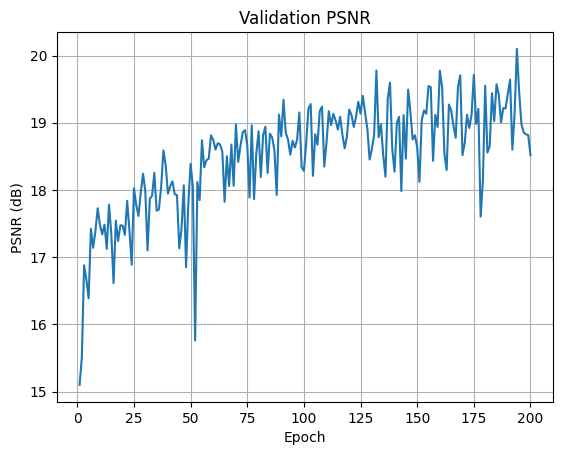

In [129]:
# Validation PSNR
plt.plot(epochs, val_psnr)
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('Validation PSNR')
plt.grid(True)
plt.savefig('validation_psnr.png', dpi=300, bbox_inches='tight')


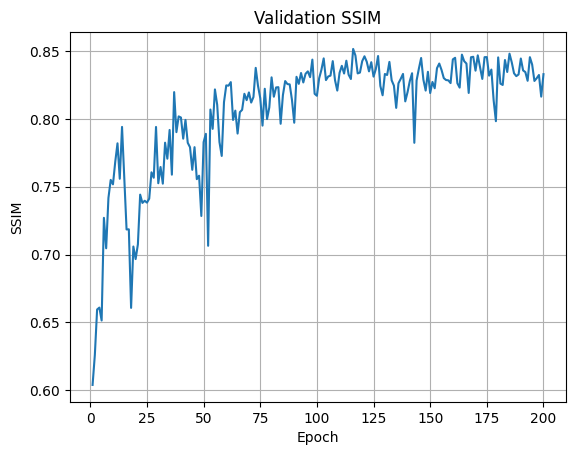

In [128]:
# Validation SSIM

plt.plot(epochs, val_ssim)
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Validation SSIM')
plt.grid(True)
plt.savefig('validation_ssim.png', dpi=300, bbox_inches='tight')

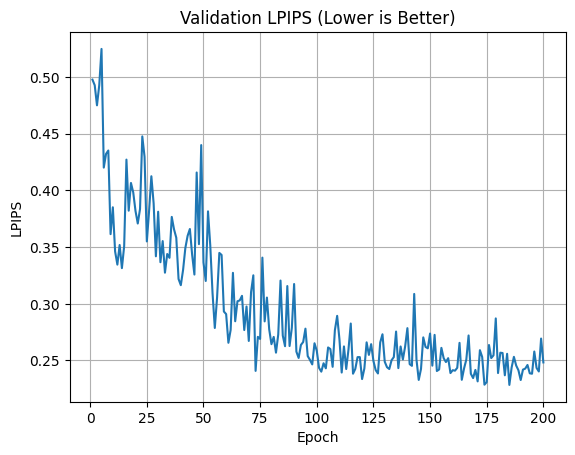

In [127]:
# Validation LPIPS
plt.plot(epochs, val_lpips)
plt.xlabel('Epoch')
plt.ylabel('LPIPS')
plt.title('Validation LPIPS (Lower is Better)')
plt.grid(True)
plt.savefig('validation_lpips.png', dpi=300, bbox_inches='tight')

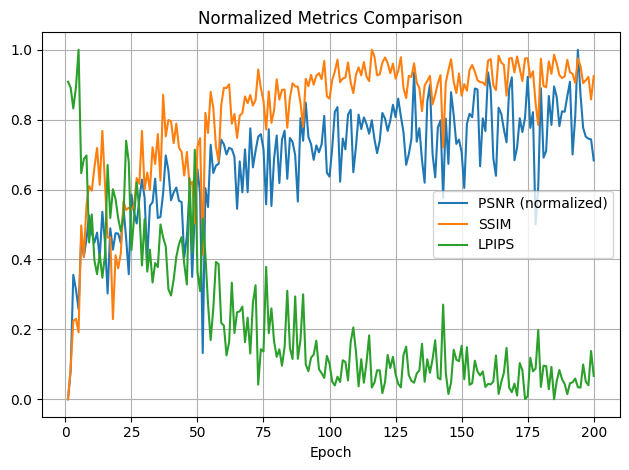

In [126]:
# Combined Metrics
val_psnr_norm = (np.array(val_psnr)-np.min(val_psnr))/(np.max(val_psnr)-np.min(val_psnr))
val_ssim_norm = (np.array(val_ssim)-np.min(val_ssim))/(np.max(val_ssim)-np.min(val_ssim))
val_lpips_norm = (np.array(val_lpips)-np.min(val_lpips))/(np.max(val_lpips)-np.min(val_lpips))

plt.plot(epochs, val_psnr_norm, label='PSNR (normalized)')
plt.plot(epochs, val_ssim_norm, label='SSIM')
plt.plot(epochs, val_lpips_norm, label='LPIPS')
plt.xlabel('Epoch')
plt.title('Normalized Metrics Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

### TESTING ON REAL WORLD IMAGES (CAPTURED BY US)

In [52]:
generator = Generator().to(device)
# Load model with explicit CPU mapping
state_dict = torch.load("RRDB_SE_CHECKPOINTS/epoch_182.pth", map_location='cpu')
generator.load_state_dict(state_dict['generator'])

<All keys matched successfully>

In [53]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import io
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set device (automatically handles CPU/GPU)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# Image transformations
transform = transforms.Compose([
    transforms.Resize((225, 225)),
    transforms.ToTensor()
])

# Create file upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    clear_output(wait=True)
    display(upload_widget)

    # Load model with proper device mapping
    generator = Generator().to(device)
    state_dict = torch.load("RRDB_SE_CHECKPOINTS/epoch_182.pth", map_location=device)
    # generator.load_state_dict(state_dict['generator'], strict=False)
    generator.load_state_dict(state_dict) # use this for best model.pth

    # Process uploaded image - NEW WAY to handle file upload
    if not upload_widget.value:
        return

    for filename, file_info in upload_widget.value.items():
        image_bytes = file_info['content']
        pil_image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

        # Transform and process
        input_tensor = transform(pil_image).unsqueeze(0).to(device)

        generator.eval()
        with torch.no_grad():
            enhanced_tensor = generator(input_tensor)

        enhanced_tensor = torch.clamp(enhanced_tensor, 0, 1).cpu().squeeze(0)
        enhanced_image = transforms.ToPILImage()(enhanced_tensor)

        # Display results
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(pil_image)
        plt.title("Original Low-Light")
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(enhanced_image)
        plt.title("Enhanced High-Light")
        plt.axis("off")

        plt.show()



In [54]:
def on_upload_change(change):
    clear_output(wait=True)
    display(upload_widget)

    # Load model (with flexible state_dict handling)
    generator = Generator().to(device)
    state_dict = torch.load("RRDB_SE_CHECKPOINTS/epoch_182.pth", map_location=device)
    if isinstance(state_dict, dict) and 'generator' in state_dict:
        generator.load_state_dict(state_dict['generator'], strict=False)
    else:
        generator.load_state_dict(state_dict, strict=False)

    # Handle new FileUpload value format (tuple of dictionaries)
    if not upload_widget.value:
        return
    
    # Get first uploaded file (even if multiple=False)
    uploaded_file = upload_widget.value[0]  # Gets first tuple element
    
    # Process the image
    image_bytes = uploaded_file['content']
    pil_image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    
    # Transform and process
    input_tensor = transform(pil_image).unsqueeze(0).to(device)
    
    generator.eval()
    with torch.no_grad():
        enhanced_tensor = generator(input_tensor)
    
    enhanced_tensor = torch.clamp(enhanced_tensor, 0, 1).cpu().squeeze(0)
    enhanced_image = transforms.ToPILImage()(enhanced_tensor)
    
    # Display results
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(pil_image)
    plt.title("Original Low-Light")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(enhanced_image)
    plt.title("Enhanced High-Light")
    plt.axis("off")
    
    plt.show()

In [251]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value=({'name': 'test_2.jpg', 'type': 'image/jpeg', 'size': 61333, 'content': <memory at 0x7f3897ce…

In [254]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value=({'name': 'test_2.jpg', 'type': 'image/jpeg', 'size': 61333, 'content': <memory at 0x7f3897ce…

In [2]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

NameError: name 'upload_widget' is not defined

In [3]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

NameError: name 'upload_widget' is not defined

In [1]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

NameError: name 'upload_widget' is not defined